# Movie Revenue Data Pipeline & Star Schema Modeling

**Author:** Justyna Walczyna  
**Tools:** Python, Pandas, SQLite, OMDb API, Jupyter Notebook, ChatGPT  
**Project Goal:** Build an end-to-end data pipeline that processes daily movie revenue data, enriches it with metadata from the OMDb API, transforms it into a dimensional star schema, stores it in a SQLite database, and enables analytical queries and visualizations.

In [10]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

sns.set(style="whitegrid")


## 1. Load and Explore CSV Data

In [ ]:
revenue_df = pd.read_csv("revenues_per_day.csv")

revenue_df.head() 

,id,date,title,revenue,theaters,distributor
0,8b19ad43-3a7e-b14b-49e9-1f7a0eb1568e,2004-09-20,Sky Captain and the World of Tomorrow,925482,3170.0,Paramount Pictures
1,481fc700-fcdd-1919-c53c-09fcd423a596,2004-09-20,Resident Evil: Apocalypse,643680,3284.0,Screen Gems
2,06719cc2-c05e-8c0b-56b6-b8b13e056509,2004-09-20,Mr 3000,425375,2736.0,Walt Disney Studios Motion Pictures
3,3be8e4a8-2716-00be-80be-eb342ba3cbe7,2004-09-20,Wimbledon,416970,2034.0,Universal Pictures
4,c5f26b59-6a64-ae8e-8f58-7cefb09eadfe,2004-09-20,Cellular,412000,2749.0,New Line Cinema


In [ ]:
revenue_df.info()  # column types and nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337818 entries, 0 to 337817
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           337818 non-null  object 
 1   date         337818 non-null  object 
 2   title        337818 non-null  object 
 3   revenue      337818 non-null  int64  
 4   theaters     337657 non-null  float64
 5   distributor  337593 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 15.5+ MB


In [13]:
revenue_df.describe()  # basic statistics

,revenue,theaters
count,3.378180e+05,337657.000000
mean,6.071642e+05,848.611597
std,2.323203e+06,1137.442240
min,0.000000e+00,1.000000
25%,6.592000e+03,45.000000
50%,4.077500e+04,226.000000
75%,3.029205e+05,1402.000000
max,1.574616e+08,4931.000000


In [ ]:
revenue_df.isnull().sum()  # number of missing values in each column

id               0
date             0
title            0
revenue          0
theaters       161
distributor    225
dtype: int64

In [15]:
revenue_df['date'].min(), revenue_df['date'].max()

('2000-01-01', '2023-03-06')

In [55]:
revenue_df['title'].nunique(), revenue_df['distributor'].value_counts()

(6545,
 Warner Bros.                           41374
 Twentieth Century Fox                  28529
 Universal Pictures                     27273
 Walt Disney Studios Motion Pictures    18283
 Paramount Pictures                     18206
                                        ...  
 Utopia                                     1
 Madman Entertainment                       1
 Fox Trail Productions                      1
 Flyhigh Cinemas                            1
 Artsploitation Films                       1
 Name: distributor, Length: 362, dtype: int64)

In [57]:
revenue_df.duplicated().sum()
# no duplicates

0

Increase/decrease of revenue over time:

Max revenue: 157461641
Min revenue (excluding 0): 1
Average revenue: 607164.1982990841


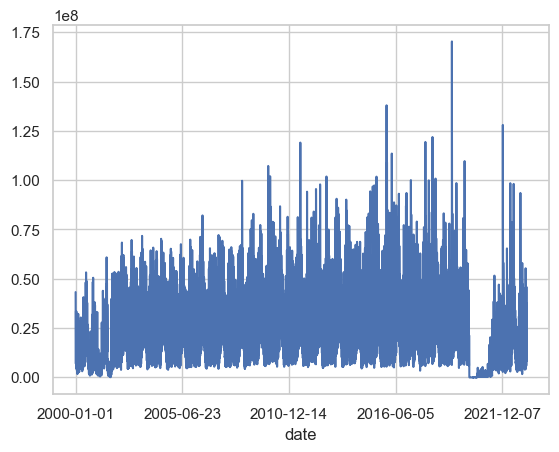

In [59]:
revenue_df.groupby('date')['revenue'].sum().plot()
print("Max revenue:", revenue_df['revenue'].max())
print("Min revenue (excluding 0):", revenue_df[revenue_df['revenue'] > 0]['revenue'].min())
print("Average revenue:", revenue_df['revenue'].mean())

## 2. Enrich Movie Metadata with OMDb API

Retrieved additional data for each unique movie title using the OMDb API, including genre, director, runtime, year, main role actors, awards and IMDb rating.


In [ ]:
import time
##!pip install tqdm
from tqdm import tqdm

API_KEY = "986539"  

unique_titles = revenue_df["title"].dropna().unique()

def get_movie_metadata(title):
    url = f"http://www.omdbapi.com/?t={title}&apikey={API_KEY}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if data.get("Response") == "True":
            return {
                "title": data.get("Title"),            # movie title
                "year": data.get("Year"),              # release year
                "genre": data.get("Genre"),            # genre of movie
                "director": data.get("Director"),      # director
                "runtime": data.get("Runtime"),        # duration
                "imdb_rating": data.get("imdbRating"), # IMDb rating
                "actors": data.get("Actors"),          # main roles
                "awards": data.get("Awards"),          # awards
                "box_office": data.get("BoxOffice"),   # Box Office revenue
                "metascore": data.get("Metascore")     # Metascore from Metacritic
            }
    return {
        "title": title,
        "year": None,
        "genre": None,
        "director": None,
        "runtime": None,
        "imdb_rating": None,
        "actors": None,
        "awards": None,
        "box_office": None,
        "metascore": None
    }


# Downloading metadata for unique movies
metadata = []
print("Pobieranie danych z OMDb API...")
for title in tqdm(unique_titles):
    meta = get_movie_metadata(title)
    metadata.append(meta)
    time.sleep(0.3)  

metadata_df = pd.DataFrame(metadata)

merged_df = pd.merge(revenue_df, metadata_df, on="title", how="left")

merged_df.to_csv("enriched_revenue_data.csv", index=False)
print("✅ Dane wzbogacone i zapisane jako 'enriched_revenue_data.csv'")



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Pobieranie danych z OMDb API...


100%|██████████| 6545/6545 [1:23:49<00:00,  1.30it/s]    


✅ Dane wzbogacone i zapisane jako 'enriched_revenue_data.csv'


In [19]:
enriched_df = pd.read_csv("enriched_revenue_data.csv")
enriched_df.head()


C:\Users\walcz\AppData\Local\Temp\ipykernel_31404\1835590818.py:1: DtypeWarning: Columns (6,7,8,9,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  enriched_df = pd.read_csv("enriched_revenue_data.csv")


,id,date,title,revenue,theaters,distributor,year,genre,director,runtime,imdb_rating,actors,awards,box_office,metascore
0,8b19ad43-3a7e-b14b-49e9-1f7a0eb1568e,2004-09-20,Sky Captain and the World of Tomorrow,925482,3170.0,Paramount Pictures,2004,"Action, Adventure, Mystery",Kerry Conran,106 min,6.1,"Gwyneth Paltrow, Jude Law, Angelina Jolie",8 wins & 19 nominations total,"$37,762,677",64.0
1,481fc700-fcdd-1919-c53c-09fcd423a596,2004-09-20,Resident Evil: Apocalypse,643680,3284.0,Screen Gems,2004,"Action, Horror, Sci-Fi",Alexander Witt,94 min,6.1,"Milla Jovovich, Sienna Guillory, Eric Mabius",6 wins & 3 nominations total,"$51,201,453",36.0
2,06719cc2-c05e-8c0b-56b6-b8b13e056509,2004-09-20,Mr 3000,425375,2736.0,Walt Disney Studios Motion Pictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3be8e4a8-2716-00be-80be-eb342ba3cbe7,2004-09-20,Wimbledon,416970,2034.0,Universal Pictures,2004,"Comedy, Romance, Sport",Richard Loncraine,98 min,6.3,"Kirsten Dunst, Paul Bettany, Jon Favreau",1 nomination total,"$17,001,133",59.0
4,c5f26b59-6a64-ae8e-8f58-7cefb09eadfe,2004-09-20,Cellular,412000,2749.0,New Line Cinema,2004,"Action, Crime, Thriller",David R. Ellis,94 min,6.5,"Kim Basinger, Chris Evans, Jason Statham",2 nominations total,"$32,003,620",60.0


## 3. Data Modeling 
Star schema diagram (link to dbdiagram.io: https://dbdiagram.io/d/6861aad8f413ba35086a39c2).

Fact Table: revenue

Dimensions: movie, date, distributor, director, actor

Bridge Table: movie-actor

## 4. End-to-End Data Pipeline

This pipeline loads raw box office data (`revenues_per_day.csv`), enriches it with metadata from the OMDb API (e.g. genre, runtime, ratings), and structures the final dataset into a star schema. The final dataset is saved in an SQLite database (`movies_star_schema.db`), ready for analytical queries and reporting.


In [ ]:
import pandas as pd
import sqlite3

df = pd.read_csv("enriched_revenue_data.csv")

# ======== TABLE dim_movie ========
dim_movie = df[["title", "year", "genre", "director", "runtime", "imdb_rating", "metascore", "box_office", "awards"]].drop_duplicates().reset_index(drop=True)
dim_movie["movie_id"] = dim_movie.index + 1

# ======== TABLE dim_distributor ========
dim_distributor = df[["distributor"]].dropna().drop_duplicates().reset_index(drop=True)
dim_distributor["distributor_id"] = dim_distributor.index + 1

# ======== TABLE dim_time ========
df["date"] = pd.to_datetime(df["date"])
dim_time = df[["date"]].drop_duplicates().reset_index(drop=True)
dim_time["day"] = dim_time["date"].dt.day
dim_time["month"] = dim_time["date"].dt.month
dim_time["year"] = dim_time["date"].dt.year
dim_time["weekday"] = dim_time["date"].dt.day_name()

# ======== TABLE dim_actor + bridge_movie_actor ========
actor_rows = []
for _, row in df.iterrows():
    if pd.isna(row["actors"]):
        continue
    movie_title = row["title"]
    for actor in row["actors"].split(","):
        actor_rows.append({"title": movie_title, "actor_name": actor.strip()})

bridge_df = pd.DataFrame(actor_rows).drop_duplicates()
dim_actor = pd.DataFrame({"name": bridge_df["actor_name"].unique()})
dim_actor["actor_id"] = dim_actor.index + 1
bridge_movie_actor = bridge_df.merge(dim_actor, left_on="actor_name", right_on="name") \
                              .merge(dim_movie, on="title") \
                              [["movie_id", "actor_id"]].drop_duplicates()

# ======== TABLE fact_revenue ========
fact_df = df.merge(dim_movie, on="title") \
            .merge(dim_distributor, on="distributor") \
            .merge(dim_time, on="date")
fact_revenue = fact_df[["movie_id", "distributor_id", "date", "revenue", "theaters"]].drop_duplicates().reset_index(drop=True)
fact_revenue["revenue_id"] = fact_revenue.index + 1

# ======== to SQLite ========
conn = sqlite3.connect("movies_star_schema.db")

dim_movie.to_sql("dim_movie", conn, index=False, if_exists="replace")
dim_distributor.to_sql("dim_distributor", conn, index=False, if_exists="replace")
dim_time.to_sql("dim_time", conn, index=False, if_exists="replace")
dim_actor.to_sql("dim_actor", conn, index=False, if_exists="replace")
bridge_movie_actor.to_sql("bridge_movie_actor", conn, index=False, if_exists="replace")
fact_revenue.to_sql("fact_revenue", conn, index=False, if_exists="replace")

conn.close()

print("✅ Gotowe! Baza 'movies_star_schema.db' została utworzona.")


C:\Users\walcz\AppData\Local\Temp\ipykernel_31404\1676165015.py:4: DtypeWarning: Columns (6,7,8,9,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("enriched_revenue_data.csv")


✅ Gotowe! Baza 'movies_star_schema.db' została utworzona.


In [ ]:
# database connecting
conn = sqlite3.connect("movies_star_schema.db")
cursor = conn.cursor()

print("Tabela: fact_revenue")
display(fact_revenue.head())

print("Tabela: bridge_movie_actor")
display(bridge_movie_actor.head())

print("Tabela: dim_actor")
display(dim_actor.head())

print("Tabela: dim_time")
display(dim_time.head())

print("Tabela: dim_distributor")
display(dim_distributor.head())

print("Tabela: dim_movie")
display(dim_movie.head())

# closed connection
conn.close()

Tabela: fact_revenue


,movie_id,distributor_id,date,revenue,theaters,revenue_id
0,1,1,2004-09-20,925482,3170.0,1
1,7,1,2004-09-20,188926,2610.0,2
2,17,1,2004-09-20,45706,628.0,3
3,25,1,2004-09-20,12353,319.0,4
4,2,2,2004-09-20,643680,3284.0,5


Tabela: bridge_movie_actor


,movie_id,actor_id
0,1,1
1,1,2
2,1,3
3,196,1
4,196,311


Tabela: dim_actor


,name,actor_id
0,Gwyneth Paltrow,1
1,Jude Law,2
2,Angelina Jolie,3
3,Milla Jovovich,4
4,Sienna Guillory,5


Tabela: dim_time


,date,day,month,year,weekday
0,2004-09-20,20,9,2004,Monday
1,2017-08-16,16,8,2017,Wednesday
2,2002-09-07,7,9,2002,Saturday
3,2001-09-02,2,9,2001,Sunday
4,2000-02-03,3,2,2000,Thursday


Tabela: dim_distributor


,distributor,distributor_id
0,Paramount Pictures,1
1,Screen Gems,2
2,Walt Disney Studios Motion Pictures,3
3,Universal Pictures,4
4,New Line Cinema,5


Tabela: dim_movie


,title,year,genre,director,runtime,imdb_rating,metascore,box_office,awards,movie_id
0,Sky Captain and the World of Tomorrow,2004,"Action, Adventure, Mystery",Kerry Conran,106 min,6.1,64.0,"$37,762,677",8 wins & 19 nominations total,1
1,Resident Evil: Apocalypse,2004,"Action, Horror, Sci-Fi",Alexander Witt,94 min,6.1,36.0,"$51,201,453",6 wins & 3 nominations total,2
2,Mr 3000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3,Wimbledon,2004,"Comedy, Romance, Sport",Richard Loncraine,98 min,6.3,59.0,"$17,001,133",1 nomination total,4
4,Cellular,2004,"Action, Crime, Thriller",David R. Ellis,94 min,6.5,60.0,"$32,003,620",2 nominations total,5


## 5. Creatd a Ranking Dashboard

Full dashboard is available under the link: https://lookerstudio.google.com/s/iQ9AiY_5oyE

Short analysis below:
1. Top 10 highest-grossing movies

2. Average revenue per day

3. Bar chart 

Top 10 Movies by Total Revenue


,title,total_revenue
0,Star Wars: Episode VII - The Force Awakens,935644139
1,Avengers: Endgame,858373000
2,Spider-Man: No Way Home,804059711
3,Avatar,749766139
4,Top Gun: Maverick,716981130
5,Black Panther,700059566
6,Avengers: Infinity War,678815482
7,Avatar: The Way of Water,670104560
8,Jurassic World,652197981
9,Star Wars: Episode VIII - The Last Jedi,620181382


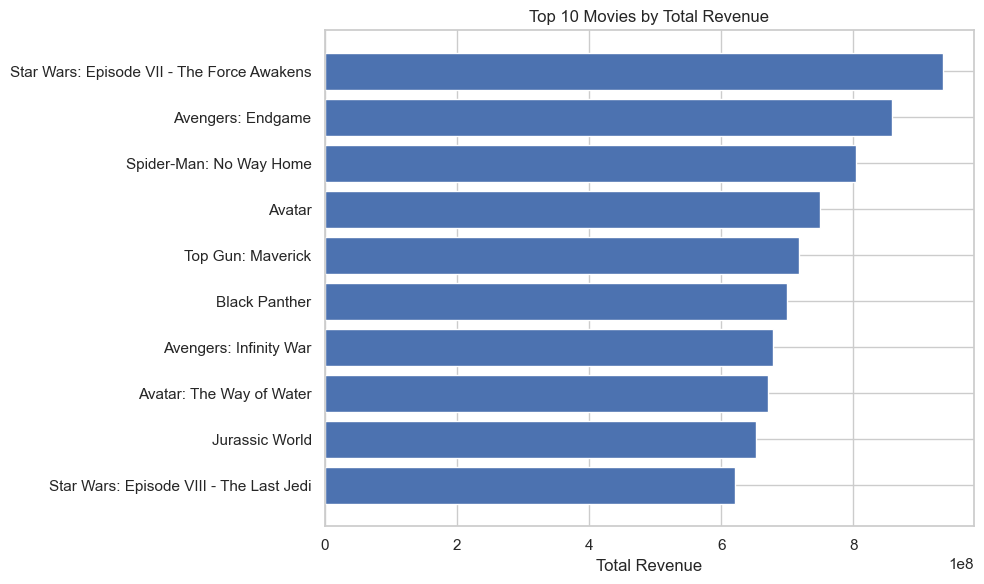

In [ ]:

conn = sqlite3.connect("movies_star_schema.db")


query = """
SELECT m.title, SUM(f.revenue) as total_revenue
FROM fact_revenue f
JOIN dim_movie m ON f.movie_id = m.movie_id
GROUP BY m.title
ORDER BY total_revenue DESC
LIMIT 10
"""
top_movies_df = pd.read_sql(query, conn)
conn.close()

print("Top 10 Movies by Total Revenue")
display(top_movies_df)

plt.figure(figsize=(10,6))
plt.barh(top_movies_df["title"][::-1], top_movies_df["total_revenue"][::-1])
plt.xlabel("Total Revenue")
plt.title("Top 10 Movies by Total Revenue")
plt.tight_layout()
plt.show()


Tabela: Średni przychód dzienny


,date,avg_revenue
0,2000-01-01 00:00:00,4.326934e+06
1,2000-01-02 00:00:00,2.553458e+06
2,2000-01-03 00:00:00,9.587316e+05
3,2000-01-04 00:00:00,6.830514e+05
4,2000-01-05 00:00:00,6.029058e+05
5,2000-01-06 00:00:00,5.790470e+05
6,2000-01-07 00:00:00,1.830043e+06
7,2000-01-08 00:00:00,3.056130e+06
8,2000-01-09 00:00:00,1.649262e+06
9,2000-01-10 00:00:00,3.859995e+05


C:\Users\walcz\AppData\Local\Temp\ipykernel_31404\400844578.py:31: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\walcz\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


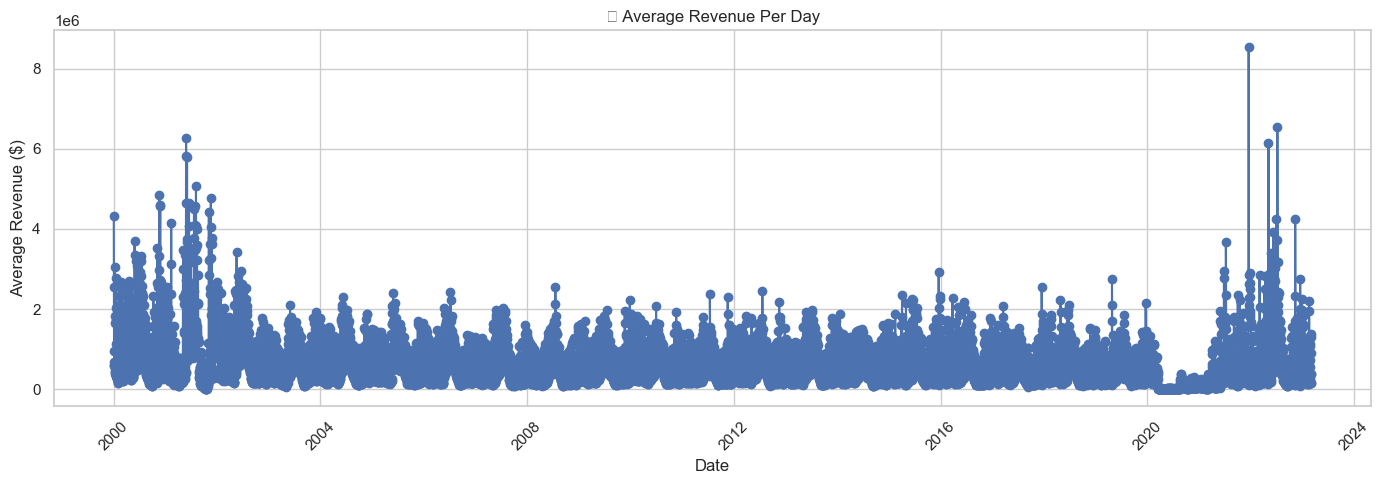

In [ ]:


conn = sqlite3.connect("movies_star_schema.db")


query = """
SELECT 
    date,
    AVG(revenue) AS avg_revenue
FROM fact_revenue
GROUP BY date
ORDER BY date;
"""

avg_df = pd.read_sql_query(query, conn)


conn.close()

print("Tabela: Średni przychód dzienny")
display(avg_df.head(10))

plt.figure(figsize=(14, 5))
plt.plot(pd.to_datetime(avg_df['date']), avg_df['avg_revenue'], marker='o')
plt.title(" Average Revenue Per Day")
plt.xlabel("Date")
plt.ylabel("Average Revenue ($)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()